In [5]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import glob
from os import path

In [6]:
%matplotlib inline

In [7]:
!ls data/NYT/

ls: data/NYT/: No such file or directory


In [8]:
def load_nyt_json(filename):
    obj = json.load(open(filename))
    words = obj["graph_data"]
    assert len(words) == 1
    only_word = words[0]
    term1 = only_word["term"]
    term2 = path.basename(filename).split(".")[0]
    assert term1 == term2

    df = pd.DataFrame.from_records(only_word["data"])
    df = df.rename(columns={"total_articles_published": "Total", "article_matches": term1})
    database = df[["Total", term1, "year"]]
    return term1, database

In [9]:
def load_nyt_database():
    word, database = load_nyt_json("data/NYT_new/bicultural.json")

    for file in glob.glob("data/NYT_new/*json"):
      word, df = load_nyt_json(file)
      if word == "bicultural": continue
      df.drop("Total", 1, inplace=True)
      df = df.rename(columns={"article_matches": word})
      database = pd.merge(database, df, on="year", how="outer")

    database.set_index("year", inplace=True)
    values = (database.values.T / database.Total.values).T
    values[:, 0] = database.Total.values
    database_norm = pd.DataFrame(data=values, columns=database.columns, index=database.index)
    return database_norm

In [10]:
database_norm = load_nyt_database()

In [24]:
def plot_both(words):
    axis_1 = df1.plot(style = {w:"-{}".format(next(marker)) for w in words})
    axis_1.set_ylabel("Percentage of New York Times Articles($\%$)")
    axis_1.set_xlabel("Year")
     #_ = axis_1.legend(loc='upper left', ncol=2)

(1960, 2015)

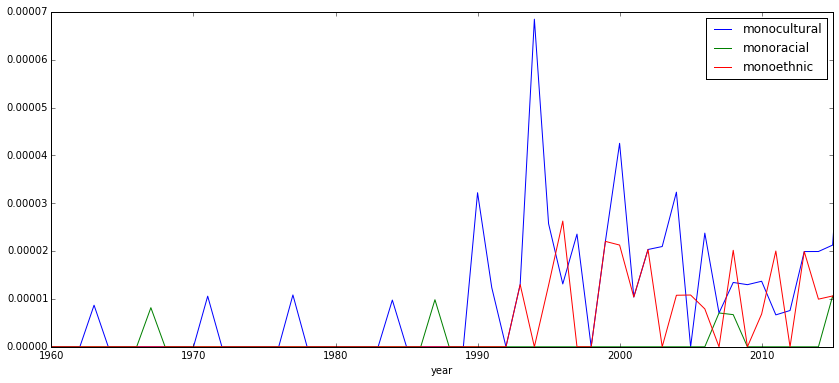

In [22]:
_ = database_norm[['monocultural', 'monoracial', 'monoethnic']].plot(figsize=(14,6))
plt.xlim(1960, 2015)

(1890, 2015)

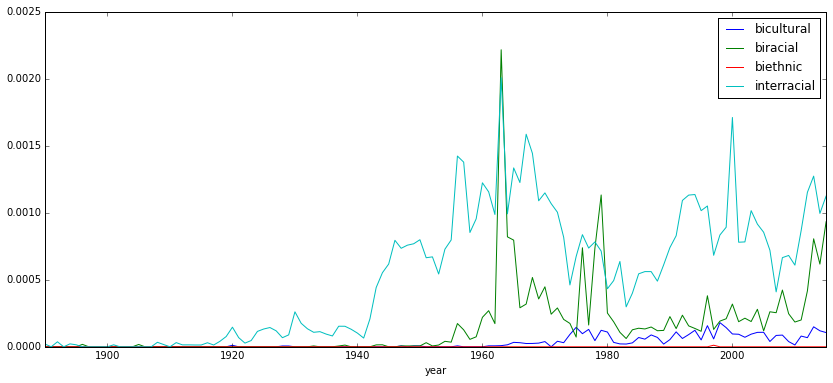

In [15]:
_ = database_norm[['bicultural', 'biracial', 'biethnic', 'interracial']].plot(figsize=(14,6))
plt.xlim(1890, 2015)

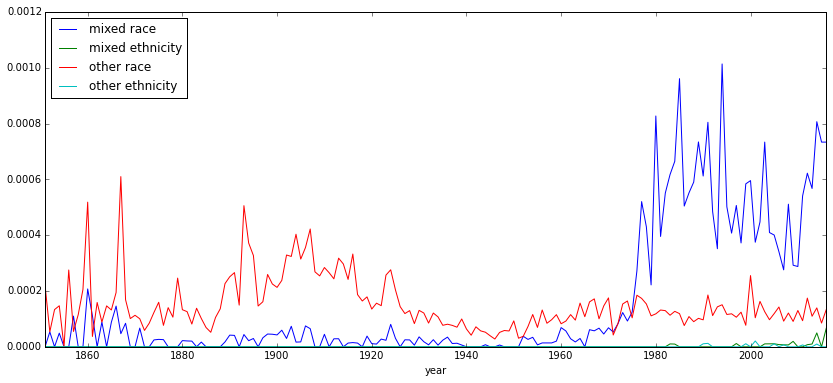

In [16]:
_ = database_norm[['mixed race', 'mixed ethnicity', 'other race', 'other ethnicity']].plot(figsize=(14,6))

(1950, 2015)

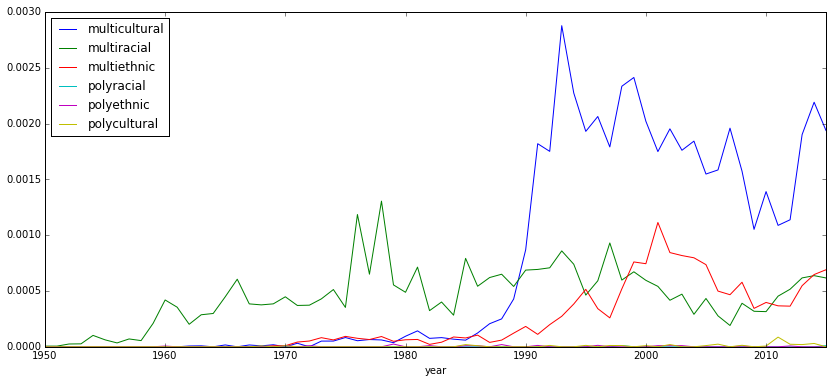

In [18]:
_ = database_norm[['multicultural', 'multiracial', 'multiethnic', 'polyracial', 'polyethnic', 'polycultural']].plot(figsize=(14,6)) 
plt.xlim(1950, 2015)

(1920, 2015)

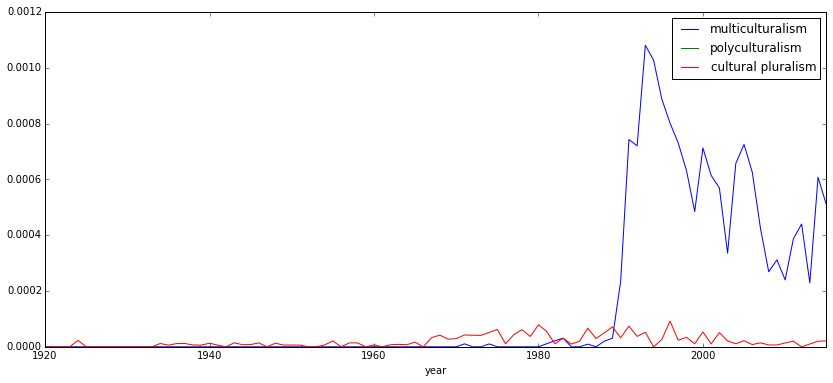

In [19]:
_ = database_norm[['multiculturalism', 'polyculturalism', 'cultural pluralism']].plot(figsize=(14,6))
plt.xlim(1920, 2015)

polyculturalism has no frequency in NYT

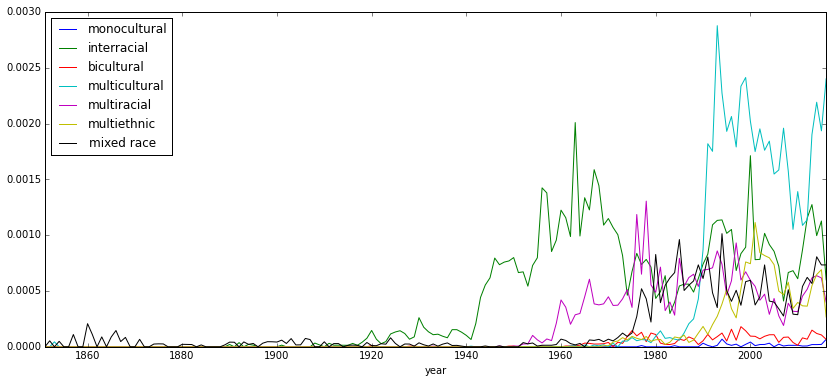

In [20]:
_ = database_norm[['monocultural', 'interracial', 'bicultural', 'multicultural', 'multiracial', 'multiethnic', 'mixed race']].plot(figsize=(14,6))

# To Do

1. Smoothen lines
1. Make in grayscale 
1. Use solid, dashed, and dotted lines
1. Use the same axes for all graphs?
1. Add Axis Labels and fix legend (see my attempt)